In [1]:
#Basic
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import os 

# Plotting & Mapping
import folium
import leafmap.foliumap as leafmap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#Utils
from utils import parse_header, create_dataset, filter_stations 

In [2]:
# Extract the stations information: station_name, network, lat, lon, geometry
ismn_dir = "./Dataset"
records = []

# Itrate through stations folders
for root, _, files in os.walk(ismn_dir):
    for file in files:
        if file.endswith(".stm"):  # only dataset files
            file_path = os.path.join(root, file)
            station = file.split("_")[2]
            network, _, lat, lon = parse_header(file_path)
            records.append({
                "network": network,
                "station": station,
                "lat": lat,
                "lon": lon
            })
            break
            
df = pd.DataFrame(records)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf

,network,station,lat,lon,geometry
0,USCRN,Mercury-3-SSW,36.62400,-116.02250,POINT (-116.0225 36.624)
1,USCRN,Mercury-3-SSW,36.62400,-116.02250,POINT (-116.0225 36.624)
2,USCRN,Los-Alamos-13-W,35.85840,-106.52140,POINT (-106.5214 35.8584)
3,USCRN,Durham-2-SSW,43.10920,-70.94840,POINT (-70.9484 43.1092)
4,USCRN,Tucson-11-W,32.23950,-111.16960,POINT (-111.1696 32.2395)
...,...,...,...,...,...
293,SCAN,UWPlatteville,42.70785,-90.38990,POINT (-90.3899 42.70785)
294,SCAN,PowellGardens,38.86667,-94.03333,POINT (-94.03333 38.86667)
295,SCAN,FortReno#1,35.55000,-98.01667,POINT (-98.01667 35.55)
296,SCAN,Uapb-LonokeFarm,34.85000,-91.88333,POINT (-91.88333 34.85)


In [3]:
# Plot the stations 
gdf = gdf.drop_duplicates(subset=["station"]).reset_index(drop=True)
gdf = gdf.sort_values(by='station', ascending=True).reset_index(drop=True)

print("Number of stations: ",  gdf.shape[0])

# Create a map and check the location of each cluster
center_lat, center_lon =  gdf['lat'].mean(), gdf['lon'].mean()

m = leafmap.Map(location=[center_lat, center_lon], zoom_start=3)
m.add_xyz_service("qms.EOX::Maps - Sentinel-2 cloudless")

style_function = lambda x: {'fillColor': '#3366cc', 'color': '#3366cc'}

folium.GeoJson(gdf['geometry'], style_function=style_function).add_to(m)
m

Number of stations:  293


In [4]:
# Create dataframe for the soil moisture networks
scan_df = create_dataset("./Dataset/SCAN") # Dataframe for SCAN Network
scan_df["network"] = "USCRN"

uscrn_df = create_dataset("./Dataset/USCRN") # Dataframe for USCRN Network
uscrn_df["network"] = "USCRN"

# Contact the two netwrok togehter in one dataframe
daily_sm = pd.concat([scan_df, uscrn_df])

# Add the geometry column
daily_sm = daily_sm.merge(
    gdf[['station', 'geometry']],
    on='station',
    how='left'  
)

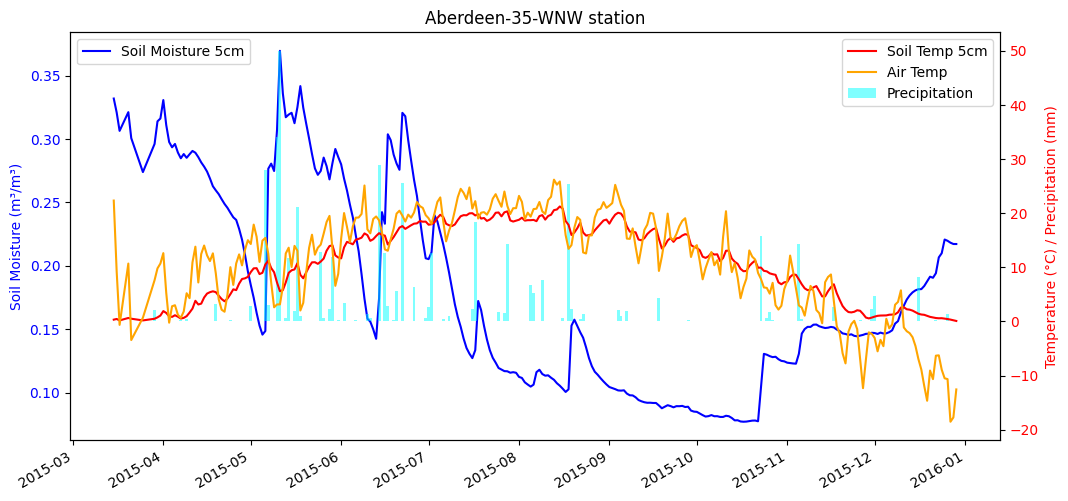

In [5]:
# Choose a random station to plot it's values
station_name = "Aberdeen-35-WNW"
df_station = daily_sm[daily_sm['station'] == station_name]

# Plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Soil moisture (left axis)
ax1.plot(df_station['datetime'], df_station['sm_5cm'], label="Soil Moisture 5cm", color="blue")
ax1.set_ylabel("Soil Moisture (m³/m³)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# Soil temperature and air temperature (right axis)
ax2 = ax1.twinx()
ax2.plot(df_station['datetime'], df_station['ts_5cm'], label="Soil Temp 5cm", color="red")
ax2.plot(df_station['datetime'], df_station['ta'], label="Air Temp", color="orange")

# Daily precipitation as bars
ax2.bar(df_station['datetime'], df_station['p'], width=1.0, label="Precipitation", color="cyan", alpha=0.5)

# Axis labels
ax2.set_ylabel("Temperature (°C) / Precipitation (mm)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Formatting
fig.autofmt_xdate()
ax1.set_title(f"{station_name} station")

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

In [6]:
# Filter the dataset so all the stations has same temporal intervals
daily_sm = daily_sm[(daily_sm['datetime'] >= datetime(2015, 3, 15)) & (daily_sm['datetime'] <= datetime(2015, 10, 31))]
daily_sm = gpd.GeoDataFrame(daily_sm, geometry=daily_sm["geometry"], crs="EPSG:4326")
daily_sm = filter_stations(daily_sm)

### Modeling 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn_extra.cluster import KMedoids
from sklearn.model_selection import StratifiedGroupKFold

from modeling import create_sequences, PinballLoss, QuantileLSTM
from utils import set_seed

In [8]:
set_seed(42)

#### Spatial Clustering using Haversine distance 

In [9]:
# Extract one unique geometry per station
stations = daily_sm.drop_duplicates(subset='station').copy()
stations['lon'] = stations.geometry.x
stations['lat'] = stations.geometry.y

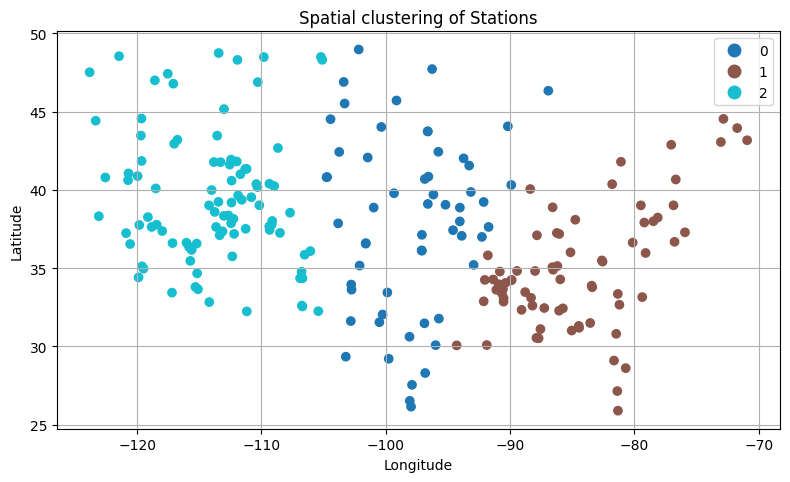

In [10]:
#Convert coordinates to radians (required for Haversine)
coords_rad = np.radians(stations[['lat', 'lon']])

# pairwise_distances with 'haversine' metric returns radians — multiply by Earth's radius to get km
dist_matrix = pairwise_distances(coords_rad, metric='haversine') * 6371  # 6371 km = Earth's radius

n_clusters = 3
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42)
stations['group'] = kmedoids.fit_predict(dist_matrix)


stations.plot(column='group', categorical=True, legend=True, figsize=(8,6))
plt.title("Spatial clustering of Stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()

plt.show()

#### Split the dataset into train/val/cal
Use StratifiedGroupKFold to ensure entire stations are in one fold, so there’s no spatial leakage (same station in train and validation).


In [11]:
stations["lat"] = stations.geometry.y
stations["lon"] = stations.geometry.x
stations.reset_index(drop=True, inplace=True)

stations.head(5)

,datetime,station,sm_5cm,ts_5cm,ta,p,network,geometry,lon,lat,group
0,2015-03-15,Abrams,0.204417,9.325000,11.362500,0.0,USCRN,POINT (-97.0859 37.1313),-97.08590,37.13130,0
1,2015-03-15,AdamsRanch#1,0.151417,8.129167,7.070833,0.0,USCRN,POINT (-105.41975 32.25296),-105.41975,32.25296,2
2,2015-03-15,Alcalde,0.237750,10.566667,8.154167,0.0,USCRN,POINT (-106.05668 36.0908),-106.05668,36.09080,2
3,2015-03-15,AlkaliMesa,0.209875,8.033333,11.662500,0.0,USCRN,POINT (-109.36429 37.67455),-109.36429,37.67455,2
4,2015-03-15,Ames,0.155792,0.108333,9.175000,0.0,USCRN,POINT (-93.73333 42.01667),-93.73333,42.01667,0


In [12]:
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

# 'y' for stratification = spatial -------> stations['group'] 
# 'groups' for grouping = station ------> stations['station']
for fold, (train_idx, val_idx) in enumerate(sgkf.split(stations, stations['group'], stations['station'])):
    train_stations = stations.loc[train_idx, 'station']
    val_stations  = stations.loc[val_idx,  'station']
    print(f"Fold {fold+1}: Train {len(train_stations)} stations, Test/Val {len(val_stations)} stations")
    break  # just show first fold

Fold 1: Train 202 stations, Test/Val 23 stations


In [13]:
temp = stations[stations['station'].isin(train_stations)].reset_index(drop=True)
set_seed(42)
sgkf2 = StratifiedGroupKFold(n_splits=2, shuffle=True)

for fold, (train_idx, cal_idx) in enumerate(sgkf2.split(temp, temp['group'], temp['station'])):
    train_stations = temp.loc[train_idx, 'station']
    cal_stations  = temp.loc[cal_idx,  'station']
    print(f"Fold {fold+1}: Train {len(train_stations)} stations, Calibration {len(cal_stations)} stations")
    break  # just show first fold


Fold 1: Train 101 stations, Calibration 101 stations


In [14]:
val_temp = stations[stations['station'].isin(val_stations)].reset_index(drop=True)
set_seed(1230771589)
sgkf3 = StratifiedGroupKFold(n_splits=2, shuffle=True)

for fold, (val_idx, test_idx) in enumerate(sgkf3.split(val_temp, val_temp['group'], val_temp['station'])):
    val_stations = val_temp.loc[val_idx, 'station']
    test_stations  = val_temp.loc[test_idx,  'station']
    print(f"Fold {fold+1}: Validation {len(val_stations)} stations, Test {len(test_stations)} stations")
    break

Fold 1: Validation 12 stations, Test 11 stations


In [15]:
train_df = daily_sm[daily_sm['station'].isin(train_stations)]
val_df = daily_sm[daily_sm['station'].isin(val_stations)]
test_df = daily_sm[daily_sm['station'].isin(test_stations)]

cal_df  = daily_sm[daily_sm['station'].isin(cal_stations)]

In [16]:
print("train dataset: ", train_df.shape, " #stations: ", train_stations.shape[0])
print("test dataset: ", test_df.shape, " #stations: ", test_stations.shape[0])

print("val dataset: ", val_df.shape, " #stations: ", val_stations.shape[0])
print("cal dataset: ", cal_df.shape, " #stations: ", cal_stations.shape[0])

train dataset:  (22757, 8)  #stations:  101
test dataset:  (2519, 8)  #stations:  11
val dataset:  (2752, 8)  #stations:  12
cal dataset:  (22714, 8)  #stations:  101


In [17]:
train_df["sm_5cm"] = train_df["sm_5cm"]*100
test_df["sm_5cm"] = test_df["sm_5cm"]*100
val_df["sm_5cm"] = val_df["sm_5cm"]*100
cal_df["sm_5cm"] = cal_df["sm_5cm"]*100

#### Prepare the dataset for LSTM

In [18]:
# this is work for MAC, change it if you are using window, or linux
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [19]:
# Create sequences per station
def create_sequences(df, variables, n_steps=15):
    X, y, stations, dates = [], [], [], []
    for st, df_st in df.groupby('station'):
        data = df_st[variables].reset_index(drop=True)
        date_col = df_st['datetime']
        for i in range(len(data) - n_steps):
            X.append(data.iloc[i:i+n_steps, :-1].values)  # input features
            y.append(data.iloc[i+n_steps, -1])            # next target
            stations.append(st)
            dates.append(date_col.iloc[i+n_steps]) 
    return np.array(X), np.array(y), np.array(stations), np.array(dates)

In [20]:
# Create sequences (15 days) for each station
variables = ["ts_5cm","ta",	"p", "sm_5cm"]
target = "sm_5cm"

train_df = train_df.sort_values(['station', 'datetime']).reset_index(drop=True)

n_steps = 15
X_train, y_train, station_labels, train_dates = create_sequences(train_df, variables, n_steps)
print(f"Shape of X: {X_train.shape}  (samples, timesteps, features)")
print(f"Shape of y: {y_train.shape}  (samples,)")

Shape of X: (21242, 15, 3)  (samples, timesteps, features)
Shape of y: (21242,)  (samples,)


In [21]:
cal_df = cal_df.sort_values(['station', 'datetime']).reset_index(drop=True)
X_cal, y_cal, station_cal_labels, cal_dates = create_sequences(cal_df, variables, n_steps)

print(f"Shape of X: {X_cal.shape}  (samples, timesteps, features)")
print(f"Shape of y: {y_cal.shape}  (samples,)")

Shape of X: (21199, 15, 3)  (samples, timesteps, features)
Shape of y: (21199,)  (samples,)


In [22]:
val_df = val_df.sort_values(['station', 'datetime']).reset_index(drop=True)
X_val, y_val, station_val_labels, val_dates = create_sequences(val_df, variables, n_steps)

print(f"Shape of X: {X_val.shape}  (samples, timesteps, features)")
print(f"Shape of y: {y_val.shape}  (samples,)")

Shape of X: (2572, 15, 3)  (samples, timesteps, features)
Shape of y: (2572,)  (samples,)


In [23]:
test_df = test_df.sort_values(['station', 'datetime']).reset_index(drop=True)
X_te, y_te, station_te_labels, te_dates = create_sequences(test_df, variables, n_steps)

print(f"Shape of X: {X_te.shape}  (samples, timesteps, features)")
print(f"Shape of y: {y_te.shape}  (samples,)")

Shape of X: (2354, 15, 3)  (samples, timesteps, features)
Shape of y: (2354,)  (samples,)


#### Train LSTM model

In [24]:
# Example hyperparameters
input_size = 3      # number of features
hidden_size = 64
quantiles = [0.05, 0.95] # for 90% coverage 
alpha = (1- quantiles[1]) + (quantiles[0]-0)
n_epochs = 30
batch_size = 32
lr = 3e-3

best_val_loss = float('inf')
epochs_no_improve = 0
patience = 5

In [25]:
# Prepare data, Convert xarray to tensors 
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

# Create Dataset # data loaders
train_ds = TensorDataset(X_train_t, y_train_t)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = TensorDataset(X_val_t, y_val_t)
val_dl = DataLoader(val_ds, batch_size=batch_size)

In [26]:
# Model training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = QuantileLSTM(input_size, hidden_size, quantiles).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=0)

loss_fns = [PinballLoss(tau) for tau in quantiles]

In [27]:
set_seed(12356) #123

In [28]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0

    for xb, yb in train_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb) 

        # Compute pinball loss for each quantile
        losses = [loss_fn(yb, preds[:, i:i+1]) for i, loss_fn in enumerate(loss_fns)]
        loss = torch.stack(losses).mean()  

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            losses = [lf(yb, preds[:, i:i+1]) for i, lf in enumerate(loss_fns)]
            val_loss += torch.stack(losses).mean().item()

    train_loss /= len(train_dl)
    val_loss /= len(val_dl)

    # Check for improvement & save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Saved new best model (val_loss: {val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

    # Adjust learning rate if plateau
    if epochs_no_improve >= patience:
        scheduler.step(val_loss)
        epochs_no_improve = 0 
        print(f"🔻 Learning rate reduced.")
        model.load_state_dict(torch.load("best_model.pt"))
    
    print(f"Epoch {epoch+1:02d} | Train {train_loss:.4f} | Val {val_loss:.4f}")


✅ Saved new best model (val_loss: 1.1198)
Epoch 01 | Train 1.7937 | Val 1.1198
⚠️ No improvement for 1 epochs.
Epoch 02 | Train 1.0244 | Val 1.1450
✅ Saved new best model (val_loss: 1.0894)
Epoch 03 | Train 0.9407 | Val 1.0894
⚠️ No improvement for 1 epochs.
Epoch 04 | Train 0.9163 | Val 1.1558
⚠️ No improvement for 2 epochs.
Epoch 05 | Train 0.9012 | Val 1.1095
⚠️ No improvement for 3 epochs.
Epoch 06 | Train 0.8939 | Val 1.1478
⚠️ No improvement for 4 epochs.
Epoch 07 | Train 0.8865 | Val 1.1374
⚠️ No improvement for 5 epochs.
🔻 Learning rate reduced.
Epoch 08 | Train 0.8885 | Val 1.1171
⚠️ No improvement for 1 epochs.
Epoch 09 | Train 0.9162 | Val 1.1095
⚠️ No improvement for 2 epochs.
Epoch 10 | Train 0.9003 | Val 1.1457
⚠️ No improvement for 3 epochs.
Epoch 11 | Train 0.8920 | Val 1.1114
⚠️ No improvement for 4 epochs.
Epoch 12 | Train 0.8803 | Val 1.1120
⚠️ No improvement for 5 epochs.
🔻 Learning rate reduced.
Epoch 13 | Train 0.8792 | Val 1.2210
⚠️ No improvement for 1 epochs.
E

#### Inference 

In [29]:
X_te_t = torch.tensor(X_te, dtype=torch.float32)
y_te_t = torch.tensor(y_te, dtype=torch.float32).view(-1, 1)

In [30]:
# Evaluate 
model = QuantileLSTM(input_size, hidden_size, quantiles).to(device)
model.load_state_dict(torch.load("best_model.pt"))

model.eval()
with torch.no_grad():
    te_preds = model(X_te_t.to(device)).cpu().numpy()  # shape (n_samples, 3)

y_te_true = y_te.copy()

lower_qr_te, upper_qr_te = te_preds.T

#### Quantitative evaluation for Quantile regression

In [31]:
df_qr_te = pd.DataFrame({'station': station_te_labels,
                        'time':te_dates,
                        'y_true': y_te_true,
                        'lower_quantile': lower_qr_te, 'upper_quantile': upper_qr_te})


In [32]:
df_qr_te['lower_quantile'] = df_qr_te['lower_quantile'].apply(lambda x: 0 if x < 0 else x)

In [33]:
# Overall Coverage (how often true values lie inside [15%, 85%])
coverage_qr = np.mean((df_qr_te.y_true.values >= df_qr_te.lower_quantile.values) & (df_qr_te.y_true.values <= df_qr_te.upper_quantile.values))
print(f"Empirical 90%,  Quantile Regression coverage: {coverage_qr*100:.1f}%")

width_qr = np.mean(df_qr_te.upper_quantile.values  - df_qr_te.lower_quantile.values)
print(f"Quantile Regression - Interval width: {width_qr}")

Empirical 90%,  Quantile Regression coverage: 98.9%
Quantile Regression - Interval width: 26.08762418597734


In [34]:
def pinball_loss_np(y, yhat, tau):
    e = y - yhat
    return np.mean(np.maximum(tau*e, (tau-1)*e))

for tau, pred in zip([0.05, 0.95], [df_qr_te.lower_quantile.values, df_qr_te.upper_quantile.values]):
    print(f"τ={tau}: pinball loss = {pinball_loss_np(df_qr_te.y_true.values, pred, tau):.4f}")


τ=0.05: pinball loss = 0.5139
τ=0.95: pinball loss = 0.7990


### Calibration using conformal statistics 

In [35]:
X_cal_t = torch.tensor(X_cal, dtype=torch.float32)
y_cal_t = torch.tensor(y_cal, dtype=torch.float32).view(-1, 1)

#### Prediction on the calibration datasets

In [36]:
model.eval()
with torch.no_grad():
    cal_preds = model(X_cal_t.to(device)).cpu().numpy()  # shape (n_samples, 3)

y_cal_true = y_cal

lower_qr_cal, upper_qr_cal = cal_preds.T

In [37]:
df_qr_cal = pd.DataFrame({'station': station_cal_labels,
                       'time':cal_dates,
                        'y_true': y_cal_true,
                        'lower_quantile': lower_qr_cal,  'upper_quantile': upper_qr_cal})

df_qr_cal['lower_quantile'] = df_qr_cal['lower_quantile'].apply(lambda x: 0 if x < 0 else x)


#### Compute residuals and conformal scores using the calibration datasets

In [38]:
df_qr_cal["lower_residuals"] = df_qr_cal["lower_quantile"] - df_qr_cal["y_true"]
df_qr_cal["upper_residuals"] = df_qr_cal["y_true"] - df_qr_cal["upper_quantile"]
df_qr_cal["scores"] = np.maximum(df_qr_cal["lower_residuals"], df_qr_cal["upper_residuals"])

#### Apply conformal adjustment on test predictions

In [39]:
alpha = 0.10
results = []
for test_date, df_t in df_qr_te.groupby('time'):
    mask = df_qr_cal["time"] < test_date
    time_window_days = 180
    if time_window_days is not None:
        mask &= (test_date - df_qr_cal["time"]).dt.days <= time_window_days
    
    df_sub = df_qr_cal.loc[mask]
    
            # here - above me
    if len(df_sub) == 0:
        # no calibration points available
        q_adj = 0
    else:
        scores_cal = df_qr_cal["scores"].values
        n = len(scores_cal)
        q_adj = np.quantile(np.sort(scores_cal), np.ceil((n + 1) * (1 - alpha)) / n)
        
    df_t["q_adj"] = q_adj
    df_t["lower_cqr_te"] = df_t["lower_quantile"] - df_t["q_adj"] 
    df_t["upper_cqr_te"] = df_t["upper_quantile"] + df_t["q_adj"]
    
    results.append(df_t)


df_qr_q = pd.concat(results, ignore_index=True)  
df_qr_q = df_qr_q[df_qr_q['q_adj']!= 0]

# Replace any negative value in q2 with 0
df_qr_q['lower_cqr_te'] = df_qr_q['lower_cqr_te'].apply(lambda x: 0 if x < 0 else x)

In [40]:
# My Previous work with Eurac
lower_cqr_te = df_qr_q["lower_cqr_te"].values 
upper_cqr_te = df_qr_q["upper_cqr_te"].values 

coverage_cqr = np.mean((df_qr_q.y_true.values >= lower_cqr_te) & (df_qr_q.y_true.values <= upper_cqr_te))
width_cqr = np.mean(upper_cqr_te  - lower_cqr_te)


print(f"Quantile Regression coverage: {coverage_qr*100:.1f}%")
print(f"Quantile Regression - Interval width: {width_qr}")
print("*"*10)
print(f"Conformalized Quantile Regression: {coverage_cqr*100:.1f}%")
print(f"Conformalized Quantile Regression - Interval width: {width_cqr}")

Quantile Regression coverage: 98.9%
Quantile Regression - Interval width: 26.08762418597734
**********
Conformalized Quantile Regression: 99.5%
Conformalized Quantile Regression - Interval width: 27.212401222299217


In [41]:
# Put the results of Conformalized Quantile Regression in data frame
df_cqr_te = pd.DataFrame({'station': df_qr_q.station.values,
                           'time':df_qr_q.time.values,
                        'y_true': df_qr_q.y_true.values,
                        'lower_quantile': lower_cqr_te, 'upper_quantile': upper_cqr_te})


### Spatio-temporal Correlation

1. Spatially Localized Conformal Quantile Regression (SLCQR).
2. Temporally Localized Conformal Quantile Regression (TCQR) 
3. Spatio-Temporal Conformal Quantile Regression (STCQR)

In [42]:
from utils import latlon_to_meters2, compute_scores, apply_lcp

In [43]:
# Convert the coordiantes from degree to meter
df_qr_cal = df_qr_cal.merge(daily_sm[["station","geometry"]].drop_duplicates(subset='station'),on="station", how="left")
df_qr_cal = gpd.GeoDataFrame(df_qr_cal, geometry='geometry', crs="4326")

coords_cal = latlon_to_meters2(df_qr_cal.geometry.x.values, df_qr_cal.geometry.y.values)
df_qr_cal['x'] = coords_cal[0]
df_qr_cal['y'] = coords_cal[1]

In [44]:
df_qr_te = df_qr_te.merge(daily_sm[["station","geometry"]].drop_duplicates(subset='station'),on="station", how="left")
df_qr_te = gpd.GeoDataFrame(df_qr_te, geometry='geometry', crs="4326")

coords_te = latlon_to_meters2(df_qr_te.geometry.x.values, df_qr_te.geometry.y.values)

df_qr_te['x'] = coords_te[0]
df_qr_te['y'] = coords_te[1]

In [45]:
spatial_bandwidth = 270000 # Spatial bandwidth in meter "270 km"
temporal_bandwidth = 15 # Temporal bandwidth in days

In [46]:
# Spatially Localized Conformal Quantile Regression (SLCQR)
df_slcqr = apply_lcp(
    df_cal=df_qr_cal,
    df_test=df_qr_te,
    alpha=0.10,
    bandwidth_space=spatial_bandwidth,
)

# Temporally Localized Conformal Quantile Regression (TCQR)
df_tcqr = apply_lcp(
    df_cal=df_qr_cal,
    df_test=df_qr_te,
    alpha=0.10,
    bandwidth_space=None,  
    bandwidth_time=temporal_bandwidth,
)


#Spatio-Temporal Conformal Quantile Regression (STCQR)
df_stcqr = apply_lcp(
    df_cal=df_qr_cal,
    df_test=df_qr_te,
    alpha=0.10,
    bandwidth_space=spatial_bandwidth,    
    bandwidth_time=temporal_bandwidth,         
)

In [47]:
# Spatially Localized Conformal Quantile Regression (SLCQR)
lower_slcqr_te = df_slcqr["PI_lower"] # widen downward
upper_slcqr_te = df_slcqr["PI_upper"] # widen upward

coverage_slcqr = np.mean((df_slcqr.y_true.values >= lower_slcqr_te) & (df_slcqr.y_true.values <= upper_slcqr_te))
width_slcqr = np.mean(upper_slcqr_te  - lower_slcqr_te)

# Temporally Localized Conformal Quantile Regression (TCQR)
lower_tcqr_te = df_tcqr["PI_lower"] # widen downward
upper_tcqr_te = df_tcqr["PI_upper"] # widen upward

coverage_tcqr = np.mean((df_tcqr.y_true.values >= lower_tcqr_te) & (df_tcqr.y_true.values <= upper_tcqr_te))
width_tcqr = np.mean(upper_tcqr_te  - lower_tcqr_te)


# Spatio-Temporal Conformal Quantile Regression (STCQR)
lower_stcqr_te = df_stcqr["PI_lower"] # widen downward
upper_stcqr_te = df_stcqr["PI_upper"] # widen upward

coverage_stcqr = np.mean((df_stcqr.y_true.values >= lower_stcqr_te) & (df_stcqr.y_true.values <= upper_stcqr_te))
width_stcqr = np.mean(upper_stcqr_te  - lower_stcqr_te)


print(f"Quantile Regression coverage: {coverage_qr*100:.1f}%")
print(f"Quantile Regression - Interval width: {width_qr:.2f}")
print(f"Mean Relative Prediction Interval Width (MRPIW): {width_qr/np.mean(df_qr_te.y_true.values):.2f}")
print("*"*10)

print(f"Conformalized Quantile Regression: {coverage_cqr*100:.1f}%")
print(f"Conformalized Quantile Regression - Interval width: {width_cqr:.2f}")
print(f"Mean Relative Prediction Interval Width (MRPIW): {width_cqr/np.mean(df_qr_te.y_true.values):.2f}")
print("*"*10)

print(f"Spatially Localized Conformal Quantile Regression (SLCQR): {coverage_slcqr*100:.1f}%")
print(f"Spatially Localized Conformal Quantile Regression (SLCQR) - Interval width: {width_slcqr:.2f}")
print(f"Mean Relative Prediction Interval Width (MRPIW): {width_slcqr/np.mean(df_slcqr.y_true.values):.2f}")
print("*"*10)


print(f"Temporally Localized Conformal Quantile Regression (TCQR): {coverage_tcqr*100:.1f}%")
print(f"Temporally Localized Conformal Quantile Regression (TCQR) - Interval width: {width_tcqr:.2f}")
print(f"Mean Relative Prediction Interval Width (MRPIW): {width_tcqr/np.mean(df_tcqr.y_true.values):.2f}")
print("*"*10)

print(f"Spatio-Temporal Conformal Quantile Regression (STCQR): {coverage_stcqr*100:.1f}%")
print(f"Spatio-Temporal Conformal Quantile Regression (STCQR) - Interval width: {width_stcqr:.2f}")
print(f"Mean Relative Prediction Interval Width (MRPIW): {width_stcqr/np.mean(df_stcqr.y_true.values):.2f}")

Quantile Regression coverage: 98.9%
Quantile Regression - Interval width: 26.09
Mean Relative Prediction Interval Width (MRPIW): 1.89
**********
Conformalized Quantile Regression: 99.5%
Conformalized Quantile Regression - Interval width: 27.21
Mean Relative Prediction Interval Width (MRPIW): 1.97
**********
Spatially Localized Conformal Quantile Regression (SLCQR): 96.2%
Spatially Localized Conformal Quantile Regression (SLCQR) - Interval width: 26.38
Mean Relative Prediction Interval Width (MRPIW): 1.91
**********
Temporally Localized Conformal Quantile Regression (TCQR): 99.6%
Temporally Localized Conformal Quantile Regression (TCQR) - Interval width: 27.68
Mean Relative Prediction Interval Width (MRPIW): 2.00
**********
Spatio-Temporal Conformal Quantile Regression (STCQR): 94.4%
Spatio-Temporal Conformal Quantile Regression (STCQR) - Interval width: 24.28
Mean Relative Prediction Interval Width (MRPIW): 1.76


In [48]:
df_qr_te["interval_width"] = df_qr_te["upper_quantile"] - df_qr_te["lower_quantile"]
df_cqr_te["interval_width"] = df_cqr_te["upper_quantile"] - df_cqr_te["lower_quantile"]

df_stcqr["interval_width"] = df_stcqr["PI_upper"] - df_stcqr["PI_lower"]
df_tcqr["interval_width"] = df_tcqr["PI_upper"] - df_tcqr["PI_lower"]
df_slcqr["interval_width"] = df_slcqr["PI_upper"] - df_slcqr["PI_lower"]

# Extract the 'Width' column from each DataFrame
widths_qr = df_qr_te['interval_width']#.values
widths_cqr = df_cqr_te['interval_width']
widths_stcqr = df_stcqr['interval_width']
widths_tcqr = df_tcqr['interval_width']
widths_slcqr = df_slcqr['interval_width']

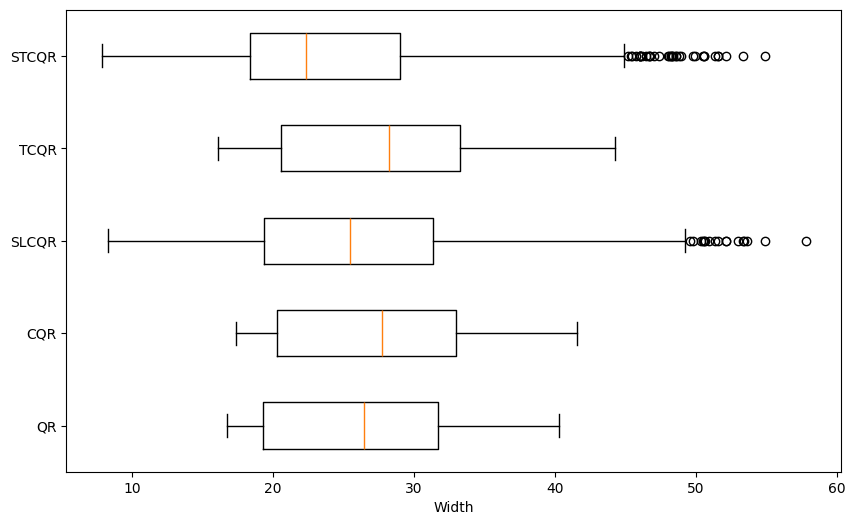

In [49]:
# Create the box plot
plt.figure(figsize=(10,6))
plt.boxplot([widths_qr, widths_cqr, widths_slcqr, widths_tcqr, widths_stcqr], 
            labels=[ "QR", "CQR", 'SLCQR',  'TCQR', 'STCQR'],
            vert=False)

plt.xlabel('Width')

plt.show()